In [50]:
# Goal: Predict the win rate of a team/combination of agents given minimal data
# such as statistics for the first few rounds (or just the team composition)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

engine = create_engine("sqlite:///data/valorant.sqlite")

scoreboard = pd.read_sql_table("Game_Scoreboard", con=engine)
rounds = pd.read_sql_table("Game_Rounds", con=engine)
games = pd.read_sql_table("Games", con=engine)

engine.dispose()

In [51]:
print("Scoreboard:")
print(scoreboard.head())
print("Rounds:")
print(rounds.head())
print("Games:")
print(games.head())

Scoreboard:
  GameID PlayerID PlayerName TeamAbbreviation    Agent    ACS  Kills  Deaths  \
0  60894     8419     Reduxx             Boos     jett  313.0   24.0    10.0   
1  60894      466     ChurmZ             Boos  chamber  227.0   16.0    10.0   
2  60894     3712   diaamond             Boos     sova  226.0   17.0     9.0   
3  60894     5099     Boltzy             Boos    viper  218.0   17.0    12.0   
4  60894     3983     Virtyy             Boos     skye   80.0    5.0    13.0   

   Assists  PlusMinus  ...  Num_4Ks  Num_5Ks  OnevOne  OnevTwo  OnevThree  \
0      3.0       14.0  ...      2.0      0.0      1.0      0.0        0.0   
1      7.0        6.0  ...      0.0      0.0      0.0      0.0        0.0   
2      8.0        8.0  ...      0.0      0.0      1.0      0.0        0.0   
3      2.0        5.0  ...      0.0      0.0      1.0      0.0        0.0   
4      3.0       -8.0  ...      0.0      0.0      0.0      0.0        0.0   

   OnevFour  OnevFive  Econ  Plants  Defuses

__Making a prediction based on just the team composition and map:__

In [52]:
# Desired DataFrame structure:
# Index: GameID, Columns: Team1, Team1 agents, Team2, Team2 agents, Map, Winner

print(len(scoreboard))
#scoreboard_grouped = scoreboard.copy().groupby('GameID')
game_ids_s = scoreboard['GameID'].unique()
print(len(game_ids_s))
#print(len(scoreboard_grouped))
print("------")
print(len(rounds))
print("------")

# Filter by common GameIDs
games = games[games['GameID'].isin(game_ids_s)]

game_ids_g = games['GameID'].unique()
scoreboard = scoreboard[scoreboard['GameID'].isin(game_ids_g)]

print(len(scoreboard))
print(len(games))
#print(scoreboard.head())

157939
15878
------
15531
------
157939
15878


In [53]:
# Group agents by GameID and TeamAbbreviation into sets
team_compositions = pd.pivot_table(
    scoreboard,
    values='Agent',  # The column containing the agents
    index=['GameID', 'TeamAbbreviation'],  # Rows will be grouped by GameID and TeamID
    aggfunc=lambda x: set(x)  # Combine agent names into a set for each team
)

# Filter GameIDs with exactly two teams
team_counts = team_compositions.groupby(level='GameID').size()
valid_game_ids = team_counts[team_counts == 2].index
team_compositions = team_compositions.loc[valid_game_ids]

# Step 2: Assign positions in each group by GameID
merged = team_compositions.merge(games, how="left", on="GameID")
merged["RowPosition"] = merged.groupby("GameID").cumcount()

# Step 3: Update TeamAbbreviation based on RowPosition
merged.loc[merged["RowPosition"] == 0, "TeamAbbreviation"] = merged["Team1"]
merged.loc[merged["RowPosition"] == 1, "TeamAbbreviation"] = merged["Team2"]

# Add column for winner
merged["Winner1"] = merged["TeamAbbreviation"] == merged["Winner"]

# Drop unnecessary columns like Team1, Team2, and RowPosition
team_compositions = merged[["GameID", "TeamAbbreviation", "Agent", "Winner1"]]


print(team_compositions.head(10))
# print(teams[teams['GameID'] == '10004'])
print(len(team_compositions.index.get_level_values(0).unique()) / 2)
# print(len(teams['GameID']))

  GameID   TeamAbbreviation                                  Agent  Winner1
0  10003       Bren Esports    {raze, omen, cypher, phoenix, sova}    False
1  10003  Attack All Around      {raze, reyna, omen, cypher, sova}     True
2  10004       Bren Esports      {jett, reyna, omen, cypher, sova}     True
3  10004  Attack All Around     {jett, reyna, killjoy, omen, sova}    False
4  10005       Bren Esports     {raze, jett, breach, omen, cypher}    False
5  10005  Attack All Around    {raze, jett, killjoy, breach, omen}     True
6  10006             HSDIRR     {raze, viper, omen, phoenix, sage}     True
7  10006           MJAOMODE  {raze, viper, killjoy, omen, phoenix}    False
8  10007             HSDIRR     {viper, jett, omen, phoenix, sage}    False
9  10007           MJAOMODE  {raze, viper, killjoy, omen, phoenix}     True
14771.0


In [54]:
selection = {'phoenix', 'omen', 'cypher', 'sage', 'raze'}
g = team_compositions[team_compositions['Agent'] == selection]
print(len(g))
s = g['Winner1'].sum()
print(s)
print("This comp's win rate is: %" + str((s/len(g)) * 100))

28
19
This comp's win rate is: %67.85714285714286


One-Hot Encoding Agents

In [55]:
# Get all unique agents
all_agents = set().union(*merged["Agent"])
all_agents.remove('')

# One-hot encode agents
def encode_agents(row_agents, all_agents):
    return {agent: 1 if agent in row_agents else 0 for agent in all_agents}

# Create a DataFrame where columns represent agents
agent_columns = merged["Agent"].apply(lambda x: encode_agents(x, all_agents))

# Expand the one-hot encoding into separate columns
agent_df = pd.DataFrame(agent_columns.tolist(), index=merged.index)

# Combine with base DataFrame
merged = pd.concat([merged, agent_df], axis=1).drop(columns=["Agent"])  # Agents no longer needed

# Some cleaning
merged_orig = merged.copy()
merged_clean = merged.drop(columns=['MatchID', 'Team1ID', 'Team2ID', 'Team1_TotalRounds',
                                    'Team2_TotalRounds', 'Team1_SideFirstHalf', 'Team2_SideFirstHalf',
                                    'Team1_RoundsFirstHalf', 'Team1_RoundsSecondtHalf', 'Team1_RoundsOT',
                                    'Team2_RoundsFirstHalf', 'Team2_RoundsSecondtHalf', 'Team2_RoundsOT',
                                    'Team1_PistolWon', 'Team1_Eco', 'Team1_EcoWon', 'Team1_SemiEco',
                                    'Team1_SemiEcoWon', 'Team1_SemiBuy', 'Team1_SemiBuyWon',
                                    'Team1_FullBuy', 'Team1_FullBuyWon', 'Team2_PistolWon', 'Team2_Eco',
                                    'Team2_EcoWon', 'Team2_SemiEco', 'Team2_SemiEcoWon', 'Team2_SemiBuy',
                                    'Team2_SemiBuyWon', 'Team2_FullBuy', 'Team2_FullBuyWon'])

merged_clean.head()

,GameID,Map,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,yoru,chamber,...,astra,raze,viper,jett,brimstone,killjoy,omen,skye,kayo,sova
0,10003,Bind,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,0,0,...,0,1,0,0,0,0,1,0,0,1
1,10003,Bind,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,0,0,...,0,1,0,0,0,0,1,0,0,1
2,10004,Haven,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,0,0,...,0,0,0,1,0,0,1,0,0,1
3,10004,Haven,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,0,0,...,0,0,0,1,0,1,1,0,0,1
4,10005,Split,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,0,0,...,0,1,0,1,0,0,1,0,0,0


Combining rows for both teams into one row

In [56]:
merged_clean['Map'] = merged_clean['Map'].astype('category')

# Split data into Team1 and Team2
team1 = merged_clean[merged_clean['Winner1'] == True]
team2 = merged_clean[merged_clean['Winner1'] == False]

# Rename columns to distinguish between Team1 and Team2.
team1 = team1.add_prefix("team1_")
team2 = team2.add_prefix("team2_")

# Combine both teams into a single row
final_df = pd.merge(team1, team2, left_on="team1_GameID", right_on="team2_GameID")

# Drop redundant columns
columns_to_drop = [
    'team1_Team1', 'team1_Team2', 'team2_Team1', 'team2_Map',
    'team2_Team2', 'team1_RowPosition', 'team2_RowPosition',
    'team1_Winner', 'team2_Winner', 'team2_GameID'
]

final_df = final_df.rename(columns={'team1_GameID': 'GameID', 'team1_TeamAbbreviation': 'Team1',
                                    'team2_TeamAbbreviation': 'Team2', 'team1_Map': 'Map',})

# One-hot encode the 'Map' column
map_dummies = pd.get_dummies(final_df['Map'], prefix='Map')

# Add the one-hot encoded columns to the DataFrame
final_df = pd.concat([final_df, map_dummies], axis=1)

# Drop the original 'Map' column as it's no longer needed
final_df = final_df.drop(columns=['Map'])

final_df = final_df.drop(columns=columns_to_drop)

# Re-position Winner1 column at end of columns
final_df['Winner1'] = final_df['team1_Winner1'] == True
final_df = final_df.drop(columns=['team1_Winner1', 'team2_Winner1'])

final_df.head()

,GameID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,team1_astra,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,Attack All Around,0,0,1,0,1,0,0,0,...,1,False,True,False,False,False,False,False,False,True
1,10004,Bren Esports,0,0,1,0,1,0,0,0,...,1,False,False,False,False,True,False,False,False,True
2,10005,Attack All Around,0,0,0,1,0,0,0,0,...,0,False,False,False,False,False,False,True,False,True
3,10006,HSDIRR,0,0,0,0,0,1,1,0,...,0,True,False,False,False,False,False,False,False,True
4,10007,MJAOMODE,0,0,0,0,0,1,0,0,...,0,False,False,False,False,True,False,False,False,True


In [57]:
final_df.iloc[:, 1:19].head()

,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,team1_astra,team1_raze,team1_viper,team1_jett,team1_brimstone,team1_killjoy,team1_omen,team1_skye,team1_kayo,team1_sova
0,Attack All Around,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1
1,Bren Esports,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,Attack All Around,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0
3,HSDIRR,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0
4,MJAOMODE,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0


In [58]:
# At this point, the winning team is always on the left, which must be fixed to prevent bias

# Randomly decide whether to swap Team1 and Team2 for each row
swap_teams = np.random.rand(len(final_df)) > 0.5

# for idx in final_df.index[swap_teams]:
#     # Swap columns for Team1 and Team2
#     temp_team_columns = final_df.loc[idx, 'Team1':'team1_breach'].copy()
#     final_df.loc[idx, 'Team1':'team1_breach'] = final_df.loc[idx, 'Team2':'team2_breach'].values
#     final_df.loc[idx, 'Team2':'team2_breach'] = temp_team_columns.values
#
#     # Flip the Winner1 column (because winner changes sides)
#     final_df.loc[idx, 'Winner1'] = not final_df.loc[idx, 'Winner1']

# Vectorized:
# team1_columns = final_df.loc[:, 'Team1':'team1_breach'].columns.tolist()
# team2_columns = final_df.loc[:, 'Team2':'team2_breach'].columns.tolist() # order of agents changed, so breach was no longer last
team1_columns = final_df.iloc[:, 1:19].columns.tolist()
team2_columns = final_df.iloc[:, 19:37].columns.tolist()

# Swap columns where swap_teams is True
temp_team1 = final_df.loc[swap_teams, team1_columns].copy()

final_df.loc[swap_teams, team1_columns] = final_df.loc[swap_teams, team2_columns].values
final_df.loc[swap_teams, team2_columns] = temp_team1.values  # Use the temporary data here

# Flip Winner1 column for swapped rows
final_df.loc[swap_teams, 'Winner1'] = ~final_df.loc[swap_teams, 'Winner1']


duplicates = final_df[final_df['Team1'] == final_df['Team2']]
print(f"Number of duplicate rows: {len(duplicates)}")

final_df.head()

Number of duplicate rows: 0


,GameID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,team1_astra,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,Bren Esports,0,0,0,0,1,1,0,0,...,1,False,True,False,False,False,False,False,False,False
1,10004,Attack All Around,0,0,1,0,0,0,0,0,...,1,False,False,False,False,True,False,False,False,False
2,10005,Bren Esports,0,0,0,1,1,0,0,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,MJAOMODE,0,0,0,0,0,1,0,0,...,0,True,False,False,False,False,False,False,False,False
4,10007,MJAOMODE,0,0,0,0,0,1,0,0,...,0,False,False,False,False,True,False,False,False,True


In [59]:
# Check Winner1 distribution
team1_wins = final_df['Winner1'].sum()
total_matches = len(final_df)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")

Team1 Wins: 7424
Team2 Wins: 7347


In [60]:
from sklearn.model_selection import train_test_split

X = final_df.drop(columns=['Team1', 'Team2', 'Winner1', 'GameID'])
y = final_df['Winner1']

# 80-20 training/testing split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X1, X2, y1, y2 = train_test_split(X, y, random_state=41,
                                  train_size=0.5)
# print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")
print(f"Training Data: {X1.shape}, {X2.shape}")

Training Data: (7385, 42), (7386, 42)


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.51      0.43      0.46      3750
        True       0.49      0.57      0.53      3635

    accuracy                           0.50      7385
   macro avg       0.50      0.50      0.49      7385
weighted avg       0.50      0.50      0.49      7385

[[1599 2151]
 [1566 2069]]
              precision    recall  f1-score   support

       False       0.49      0.54      0.52      3597
        True       0.52      0.48      0.50      3789

    accuracy                           0.51      7386
   macro avg       0.51      0.51      0.51      7386
weighted avg       0.51      0.51      0.51      7386

[[1941 1656]
 [1989 1800]]
Random Forest Accuracy: 0.4966824644549763 0.5064987814784728
Mean: 0.5015906229667246


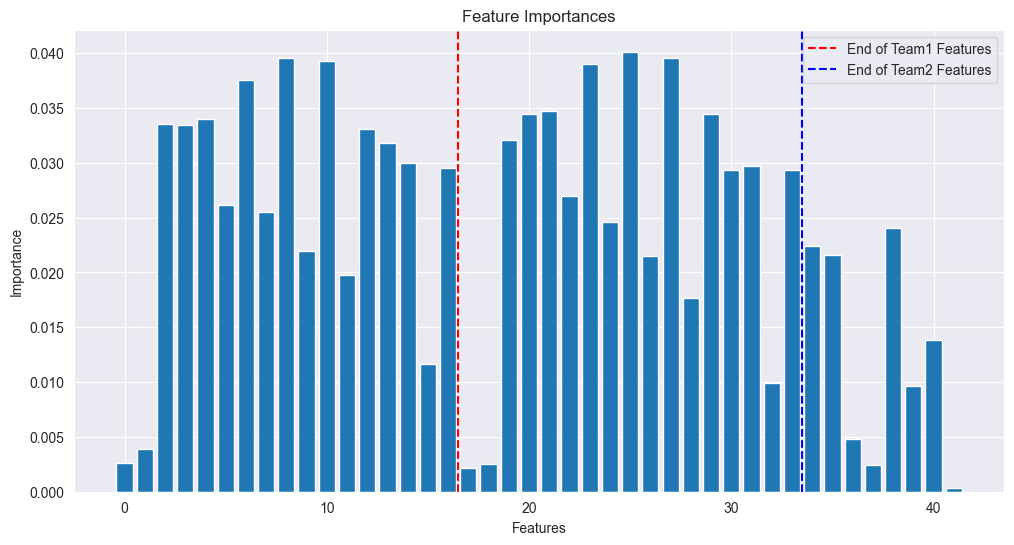

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=20,
#                                   min_samples_leaf=4, random_state=42)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=5,
                                  min_samples_leaf=2)
# (n_estimators=300, max_depth=30, min_samples_split=80,
#                                   min_samples_leaf=180)
#rf_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,min_samples_split=5, min_samples_leaf=2)


# Train model
# rf_model.fit(X_train, y_train)

# Train and test with cross-validation
y2_model = rf_model.fit(X1, y1).predict(X2)
y1_model = rf_model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

# Test model
# y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
#print(classification_report(y_test, y_pred_rf))
#print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y1, y1_model))
print(confusion_matrix(y1, y1_model))
print(classification_report(y2, y2_model))
print(confusion_matrix(y2, y2_model))
print("Random Forest Accuracy:", accuracy_score(y1, y1_model), accuracy_score(y2, y2_model))
print("Mean:", (float(accuracy_score(y1, y1_model)) + float(accuracy_score(y2, y2_model))) / 2)
importances = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances)

# Add group labels
# plt.xticks(range(len(importances)),
#            ['Team1'] * 18 + ['Team2'] * 18 + ['Map'] * len(importances[36:]), rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')

# Annotate sections
plt.axvline(x=16.5, color='red', linestyle='--', label='End of Team1 Features')
plt.axvline(x=33.5, color='blue', linestyle='--', label='End of Team2 Features')

# Add legend
plt.legend()
plt.title("Feature Importances")
plt.show()

In [62]:
print(X.columns[24:27])

Index(['team2_astra', 'team2_raze', 'team2_viper'], dtype='object')


In [167]:
# Example: Predicting a single match outcome
team1_agents = {"brimstone", "phoenix", "cypher", "jett", "sage"}
team2_agents = {"killjoy", "omen", "sova", "jett", "raze"}
map_to_predict = "Ascent"  # Replace with the selected map for prediction

# One-hot encode agents for both teams and map
team1_encoded = {f'team1_{agent}': 1 if agent in team1_agents else 0 for agent in all_agents}
team2_encoded = {f'team2_{agent}': 1 if agent in team2_agents else 0 for agent in all_agents}
all_maps = map_dummies.columns.tolist()
map_encoded = {f"{map}": (1 if map == "Map_" + map_to_predict else 0) for map in all_maps}

# Combine into a single row
input_row = pd.DataFrame([{**team1_encoded, **team2_encoded, **map_encoded}])

# Predict using the model
rf_probability = rf_model.predict_proba(input_row)[0][1] * 100  # Probability Team1 wins
rf_probability_team2 = 100 - rf_probability  # Probability Team2 wins

print("Agents:", all_agents)
print("Maps:", all_maps)
print(f"Chance of Team1 winning: {rf_probability:.2f}%")
print(f"Chance of Team2 winning: {rf_probability_team2:.2f}%")

Agents: {'yoru', 'chamber', 'reyna', 'breach', 'cypher', 'phoenix', 'sage', 'astra', 'raze', 'viper', 'jett', 'brimstone', 'killjoy', 'omen', 'skye', 'kayo', 'sova'}
Maps: ['Map_Ascent', 'Map_Bind', 'Map_Breeze', 'Map_Fracture', 'Map_Haven', 'Map_Icebox', 'Map_Split', 'Map_TBD']
Chance of Team1 winning: 41.78%
Chance of Team2 winning: 58.22%


In [45]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Vary the number of trees
    'max_depth': [5, 10, 15],  # Vary tree depth
    'min_samples_split': [2, 5, 10],  # Vary splitting criteria
    'min_samples_leaf': [1, 2, 4]  # Vary minimum samples per leaf
}

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
#grid_search.fit(X_train, y_train)
grid_search.fit(X2, y2)

# Output the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
# Note: best was {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200}
# Best Accuracy: 0.5129488668677783

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.7s


KeyboardInterrupt: 

__Accuracy based on just team composition and map is low, so I will try to increase accuracy with incremental training based on the winner of each round in a game.__

In [64]:
game_ids = final_df['GameID']
rounds_filtered = rounds[rounds['GameID'].isin(game_ids)]
print(len(rounds_filtered))
print(len(rounds))
print(len(game_ids))

# Number of games in rounds_filtered is less than in final_df,
# so another round of filtering is needed

game_ids = rounds_filtered['GameID']
final_df2 = final_df[final_df['GameID'].isin(game_ids)]
print("-----")
print(len(final_df2))
rounds_filtered.head()

14393
15531
14771
-----
14393


,GameID,Team1ID,Team2ID,RoundHistory
0,60894,6903,6020,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."
1,60895,6903,6020,"{1: {'RoundWinner': 'PHO ', 'ScoreAfterRound':..."
2,60896,6903,6020,"{1: {'RoundWinner': 'PHO ', 'ScoreAfterRound':..."
5,60888,6461,6903,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."
6,60889,6461,6903,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."


In [65]:
merged_orig.head(10)

,GameID,MatchID,Map,Team1ID,Team2ID,Team1,Team2,Winner,Team1_TotalRounds,Team2_TotalRounds,...,astra,raze,viper,jett,brimstone,killjoy,omen,skye,kayo,sova
0,10003,6031,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,13,15,...,0,1,0,0,0,0,1,0,0,1
1,10003,6031,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,13,15,...,0,1,0,0,0,0,1,0,0,1
2,10004,6031,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,13,11,...,0,0,0,1,0,0,1,0,0,1
3,10004,6031,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,13,11,...,0,0,0,1,0,1,1,0,0,1
4,10005,6031,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,13,...,0,1,0,1,0,0,1,0,0,0
5,10005,6031,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,13,...,0,1,0,1,0,1,1,0,0,0
6,10006,6034,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,13,9,...,0,1,1,0,0,0,1,0,0,0
7,10006,6034,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,13,9,...,0,1,1,0,0,1,1,0,0,0
8,10007,6034,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,11,13,...,0,0,1,1,0,0,1,0,0,0
9,10007,6034,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,11,13,...,0,1,1,0,0,1,1,0,0,0


In [66]:
merged_orig = merged_orig.drop(columns=['MatchID', 'Team1_TotalRounds',
                                    'Team2_TotalRounds', 'Team1_SideFirstHalf', 'Team2_SideFirstHalf',
                                    'Team1_RoundsFirstHalf', 'Team1_RoundsSecondtHalf', 'Team1_RoundsOT',
                                    'Team2_RoundsFirstHalf', 'Team2_RoundsSecondtHalf', 'Team2_RoundsOT',
                                    'Team1_PistolWon', 'Team1_Eco', 'Team1_EcoWon', 'Team1_SemiEco',
                                    'Team1_SemiEcoWon', 'Team1_SemiBuy', 'Team1_SemiBuyWon',
                                    'Team1_FullBuy', 'Team1_FullBuyWon', 'Team2_PistolWon', 'Team2_Eco',
                                    'Team2_EcoWon', 'Team2_SemiEco', 'Team2_SemiEcoWon', 'Team2_SemiBuy',
                                    'Team2_SemiBuyWon', 'Team2_FullBuy', 'Team2_FullBuyWon'])
merged_orig.head()

,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,astra,raze,viper,jett,brimstone,killjoy,omen,skye,kayo,sova
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,0,0,0,1,0,0,1
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,0,0,0,1,0,0,1
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,0,0,1,0,0,1,0,0,1
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,0,0,0,1,0,1,1,0,0,1
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,1,0,0,0


In [67]:
merged_orig.head(10)

,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,astra,raze,viper,jett,brimstone,killjoy,omen,skye,kayo,sova
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,0,0,0,1,0,0,1
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,0,0,0,1,0,0,1
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,0,0,1,0,0,1,0,0,1
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,0,0,0,1,0,1,1,0,0,1
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,1,0,0,0
5,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,1,0,1,1,0,0,0
6,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,0,HSDIRR,True,...,0,1,1,0,0,0,1,0,0,0
7,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,1,MJAOMODE,False,...,0,1,1,0,0,1,1,0,0,0
8,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,0,HSDIRR,False,...,0,0,1,1,0,0,1,0,0,0
9,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,1,MJAOMODE,True,...,0,1,1,0,0,1,1,0,0,0


In [68]:
import ast
import json

# Parse Round Histories Function
def parse_round_histories(rounds_df):
    """Vectorized parsing of all round histories"""
    parsed_histories = {}

    for idx, row in rounds_df.iterrows():
        game_id = row['GameID']
        try:
            # Try different parsing methods
            try:
                history = ast.literal_eval(row['RoundHistory'])
            except (SyntaxError, ValueError):
                history = json.loads(row['RoundHistory'])

            parsed_histories[game_id] = history
        except:
            # Skip problematic entries
            continue

    return parsed_histories


# Parse all round histories once
parsed_round_histories = parse_round_histories(rounds_filtered)

In [69]:
parsed_round_histories['10003']

{1: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '1-0',
  'WinType': 'defuse',
  'Team1Bank': 0.0,
  'Team2Bank': 100.0,
  'Team1BuyType': 'eco',
  'Team2BuyType': 'eco'},
 2: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '2-0',
  'WinType': 'elim',
  'Team1Bank': 5200.0,
  'Team2Bank': 10000.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'eco'},
 3: {'RoundWinner': 'AAA',
  'ScoreAfterRound': '2-1',
  'WinType': 'boom',
  'Team1Bank': 11000.0,
  'Team2Bank': 1200.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'full-buy'},
 4: {'RoundWinner': 'AAA',
  'ScoreAfterRound': '2-2',
  'WinType': 'boom',
  'Team1Bank': 4900.0,
  'Team2Bank': 9400.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'full-buy'},
 5: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '3-2',
  'WinType': 'defuse',
  'Team1Bank': 4700.0,
  'Team2Bank': 16600.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'full-buy'},
 6: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '4-2',
  'WinType': 'defuse',
  'Team1Bank': 1050

In [70]:
rounds_hist_list = []

for game_id, rounds in parsed_round_histories.items():
    for round_number, round_info in rounds.items():
        rounds_hist_list.append({'GameID': game_id, 'RoundNumber': round_number, **round_info})

rounds_hist_df = pd.DataFrame(rounds_hist_list)
print(rounds_hist_df.shape, rounds_filtered.shape)
rounds_hist_df.head(25)

(284113, 9) (14393, 4)


,GameID,RoundNumber,RoundWinner,ScoreAfterRound,WinType,Team1Bank,Team2Bank,Team1BuyType,Team2BuyType
0,60894,1,BOOS,1-0,elim,300.0,100.0,eco,eco
1,60894,2,BOOS,2-0,elim,2700.0,8600.0,semi-buy,eco
2,60894,3,BOOS,3-0,elim,12300.0,400.0,semi-buy,full-buy
3,60894,4,BOOS,4-0,elim,23600.0,9800.0,full-buy,semi-eco
4,60894,5,PHO,4-1,boom,24200.0,3300.0,full-buy,full-buy
5,60894,6,PHO,4-2,boom,10200.0,10300.0,full-buy,full-buy
6,60894,7,BOOS,5-2,elim,5700.0,8900.0,full-buy,full-buy
7,60894,8,BOOS,6-2,time,6400.0,2400.0,full-buy,semi-buy
8,60894,9,BOOS,7-2,elim,10900.0,5900.0,full-buy,semi-buy
9,60894,10,PHO,7-3,boom,16500.0,1200.0,full-buy,full-buy


In [71]:
rounds_hist_df = rounds_hist_df.drop(columns=['RoundWinner', 'WinType', 'Team1Bank', 'Team2Bank',
                             'Team1BuyType', 'Team2BuyType'])
# Using str.split() to split at the hyphen and create a Series of lists
split_scores = rounds_hist_df['ScoreAfterRound'].str.split('-', expand=True)

# Create the new columns
rounds_hist_df['Team1_RoundScore'] = pd.to_numeric(split_scores[0], errors='coerce')
rounds_hist_df['Team2_RoundScore'] = pd.to_numeric(split_scores[1], errors='coerce')

# Handle potential errors (non-numeric values, missing values)
# Fill NaN values with appropriate defaults if needed
rounds_hist_df['Team1_RoundScore'] = rounds_hist_df['Team1_RoundScore'].fillna(0)
rounds_hist_df['Team2_RoundScore'] = rounds_hist_df['Team2_RoundScore'].fillna(0)

# Ensure scores are integers
rounds_hist_df['Team1_RoundScore'] = rounds_hist_df['Team1_RoundScore'].astype(int)
rounds_hist_df['Team2_RoundScore'] = rounds_hist_df['Team2_RoundScore'].astype(int)

# Optionally remove the original column if no longer needed
# rounds_hist_df.drop('ScoreAfterRound', axis=1, inplace=True)

# Display a few rows to verify the transformation
rounds_hist_df.head()

,GameID,RoundNumber,ScoreAfterRound,Team1_RoundScore,Team2_RoundScore
0,60894,1,1-0,1,0
1,60894,2,2-0,2,0
2,60894,3,3-0,3,0
3,60894,4,4-0,4,0
4,60894,5,4-1,4,1


In [72]:
merged_orig = merged_orig[merged_orig['GameID'].isin(game_ids)]
print(merged_orig.shape)
print(len(merged_orig) / 2)
merged_orig.head(10)

(28786, 27)
14393.0


,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,astra,raze,viper,jett,brimstone,killjoy,omen,skye,kayo,sova
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,0,0,0,1,0,0,1
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,0,0,0,1,0,0,1
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,0,0,1,0,0,1,0,0,1
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,0,0,0,1,0,1,1,0,0,1
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,1,0,0,0
5,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,1,0,1,1,0,0,0
6,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,0,HSDIRR,True,...,0,1,1,0,0,0,1,0,0,0
7,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,1,MJAOMODE,False,...,0,1,1,0,0,1,1,0,0,0
8,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,0,HSDIRR,False,...,0,0,1,1,0,0,1,0,0,0
9,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,1,MJAOMODE,True,...,0,1,1,0,0,1,1,0,0,0


In [93]:
merged_orig['Map'] = merged_orig['Map'].astype('category')

# Encode Team ID into names
# merged_orig['Team1'] = str(str(merged_orig['Team1']) + '-' + str(merged_orig['Team1ID']))
# merged_orig['Team2'] = str(str(merged_orig['Team2']) + '-' + str(merged_orig['Team2ID']))

# Split data into Team1 and Team2
odds = merged_orig[merged_orig['RowPosition'] == 0]
evens = merged_orig[merged_orig['RowPosition'] == 1]

# Rename columns to distinguish between Team1 and Team2.
team1 = odds.add_prefix("team1_")
team2 = evens.add_prefix("team2_")

# Combine both teams into a single row
final_df2 = pd.merge(team1, team2, left_on="team1_GameID", right_on="team2_GameID")

# temp_team2_id = final_df2['team1_Team2ID']
# final_df2[final_df2['team1_Winner'] == final_df['team1_Team2']][]

# Drop redundant columns
# columns_to_drop = [
#     'team1_Team1', 'team1_Team2', 'team2_Team1', 'team2_Map',
#     'team2_Team2', 'team1_RowPosition', 'team2_RowPosition',
#     'team1_Winner', 'team2_Winner', 'team2_GameID',
#     'team1_Team2ID', 'team2_Team1ID'
# ]
#
# final_df2 = final_df2.rename(columns={'team1_GameID': 'GameID', 'team1_TeamAbbreviation': 'Team1',
#                                     'team2_TeamAbbreviation': 'Team2', 'team1_Map': 'Map',
#                                     'team1_Team1ID': 'Team1ID', 'team2_Team2ID': 'Team2ID'})
columns_to_drop = [
    'team1_TeamAbbreviation', 'team2_TeamAbbreviation', 'team2_Map',
    'team1_RowPosition', 'team2_RowPosition',
    'team1_Winner', 'team2_Winner', 'team2_GameID',
    'team1_Team2ID', 'team2_Team1ID', 'team1_Team2', 'team2_Team1'
]

final_df2 = final_df2.rename(columns={'team1_GameID': 'GameID', 'team1_Team1': 'Team1',
                                    'team2_Team2': 'Team2', 'team1_Map': 'Map',
                                    'team1_Team1ID': 'Team1ID', 'team2_Team2ID': 'Team2ID'})

# One-hot encode the 'Map' column
map_dummies = pd.get_dummies(final_df2['Map'], prefix='Map')

# Add the one-hot encoded columns to the DataFrame
final_df2 = pd.concat([final_df2, map_dummies], axis=1)

# Drop the original 'Map' column as it's no longer needed
final_df2 = final_df2.drop(columns=['Map'])

final_df2 = final_df2.drop(columns=columns_to_drop)

# Re-position Winner1 column at end of columns
final_df2['Winner1'] = final_df2['team1_Winner1'] == True
final_df2 = final_df2.drop(columns=['team1_Winner1', 'team2_Winner1'])

final_df2.head()

,GameID,Team1ID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,694,Bren Esports,0,0,0,0,1,1,0,...,1,False,True,False,False,False,False,False,False,False
1,10004,694,Bren Esports,0,0,1,0,1,0,0,...,1,False,False,False,False,True,False,False,False,True
2,10005,694,Bren Esports,0,0,0,1,1,0,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,685,HSDIRR,0,0,0,0,0,1,1,...,0,True,False,False,False,False,False,False,False,True
4,10007,685,HSDIRR,0,0,0,0,0,1,1,...,0,False,False,False,False,True,False,False,False,False


In [94]:
# Check Winner1 distribution
team1_wins = final_df2['Winner1'].sum()
total_matches = len(final_df2)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")

Team1 Wins: 11122
Team2 Wins: 3271


In [95]:
team1_columns = final_df2.iloc[:, 1:20].columns.tolist()
team2_columns = final_df2.iloc[:, 20:39].columns.tolist()
print(team1_columns)
print(team2_columns)

['Team1ID', 'Team1', 'team1_yoru', 'team1_chamber', 'team1_reyna', 'team1_breach', 'team1_cypher', 'team1_phoenix', 'team1_sage', 'team1_astra', 'team1_raze', 'team1_viper', 'team1_jett', 'team1_brimstone', 'team1_killjoy', 'team1_omen', 'team1_skye', 'team1_kayo', 'team1_sova']
['Team2ID', 'Team2', 'team2_yoru', 'team2_chamber', 'team2_reyna', 'team2_breach', 'team2_cypher', 'team2_phoenix', 'team2_sage', 'team2_astra', 'team2_raze', 'team2_viper', 'team2_jett', 'team2_brimstone', 'team2_killjoy', 'team2_omen', 'team2_skye', 'team2_kayo', 'team2_sova']


In [99]:
# At this point, the winning team is NOT always on the left, but the distribution is imbalanced

final_df2f = final_df2.copy()

# Randomly decide whether to swap Team1 and Team2 for each row
swap_teams = np.random.rand(len(final_df2f)) > 0.5

# Vectorized:
# team1_columns = final_df.loc[:, 'Team1':'team1_breach'].columns.tolist()
# team2_columns = final_df.loc[:, 'Team2':'team2_breach'].columns.tolist() # order of agents changed, so breach was no longer last
team1_columns = final_df2f.iloc[:, 1:20].columns.tolist()
team2_columns = final_df2f.iloc[:, 20:39].columns.tolist()

# Swap columns where swap_teams is True
temp_team1 = final_df2f.loc[swap_teams, team1_columns]

final_df2f.loc[swap_teams, team1_columns] = final_df2f.loc[swap_teams, team2_columns].values
final_df2f.loc[swap_teams, team2_columns] = temp_team1.values  # Use the temporary data here

# Flip Winner1 column for swapped rows
final_df2f.loc[swap_teams, 'Winner1'] = ~final_df2f.loc[swap_teams, 'Winner1']


duplicates = final_df2f[final_df2f['Team1'] == final_df2f['Team2']]
print(f"Number of duplicate rows: {len(duplicates)}")

print(swap_teams[0:5])
final_df2f.head()

Number of duplicate rows: 0
[ True False False  True  True]


,GameID,Team1ID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,497,Attack All Around,0,0,1,0,1,0,0,...,1,False,True,False,False,False,False,False,False,True
1,10004,694,Bren Esports,0,0,1,0,1,0,0,...,1,False,False,False,False,True,False,False,False,True
2,10005,694,Bren Esports,0,0,0,1,1,0,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,1190,MJAOMODE,0,0,0,0,0,1,0,...,0,True,False,False,False,False,False,False,False,False
4,10007,1190,MJAOMODE,0,0,0,0,0,1,0,...,0,False,False,False,False,True,False,False,False,True


In [101]:
# Check Winner1 distribution
team1_wins = final_df2f['Winner1'].sum()
total_matches = len(final_df2f)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")
print(len(final_df2f))

Team1 Wins: 7163
Team2 Wins: 7230
14393


In [102]:
# Merge with round history, flipping Team1_RoundsWon and Team2_RoundsWon
# on indices of swap_teams

game_ids_to_flip = final_df2f.loc[swap_teams]['GameID']
print(game_ids_to_flip.head())

rounds_hist_df.head()

0    10003
3    10006
4    10007
5    10008
7    10012
Name: GameID, dtype: object


,GameID,RoundNumber,ScoreAfterRound,Team1_RoundScore,Team2_RoundScore
0,60894,1,1-0,1,0
1,60894,2,2-0,2,0
2,60894,3,3-0,3,0
3,60894,4,4-0,4,0
4,60894,5,4-1,4,1


In [120]:
rounds_hist_df2 = rounds_hist_df.drop(columns=['ScoreAfterRound'])

# Step 2: Perform the merge to create a round-level dataset
# We use a left join from rounds to game data to keep all rounds
join_key = 'GameID'
merged_rounds_df = rounds_hist_df2.merge(
    final_df2f,
    on=join_key,
    how='left'
)

# Step 3: Check the merged result shape
print(f"Original game data shape: {final_df2f.shape}")
print(f"Original rounds data shape: {rounds_hist_df2.shape}")
print(f"Merged data shape: {merged_rounds_df.shape}")

# Step 4: Verify that round-specific data is preserved
# Check that we have different round scores for the same game
round_counts = merged_rounds_df.groupby(join_key).size()
print(f"\nAverage rounds per game: {round_counts.mean():.2f}")
print(f"Max rounds in a game: {round_counts.max()}")

# Display a sample of rounds from one game to verify
sample_game = round_counts.idxmax()  # Game with most rounds
sample_rounds = merged_rounds_df[merged_rounds_df[join_key] == sample_game]
print(f"\nSample rounds from game {sample_game}:")
print(sample_rounds[['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore']].head())

# Do the actual flip of round scores
swap_gameids = final_df2f.loc[swap_teams]['GameID']
swap_mask = merged_rounds_df['GameID'].isin(swap_gameids)

temp_team1_scores = merged_rounds_df.loc[swap_mask, 'Team1_RoundScore'].copy()

merged_rounds_df.loc[swap_mask, 'Team1_RoundScore'] = merged_rounds_df.loc[swap_mask, 'Team2_RoundScore'].values
merged_rounds_df.loc[swap_mask, 'Team2_RoundScore'] = temp_team1_scores.values

merged_rounds_df[merged_rounds_df['GameID'] == '10003']

Original game data shape: (14393, 48)
Original rounds data shape: (284113, 4)
Merged data shape: (284113, 51)

Average rounds per game: 20.56
Max rounds in a game: 42

Sample rounds from game 17938:
        RoundNumber  Team1_RoundScore  Team2_RoundScore
196379            1                 1                 0
196380            2                 2                 0
196381            3                 2                 1
196382            4                 2                 2
196383            5                 2                 3


,GameID,RoundNumber,Team1_RoundScore,Team2_RoundScore,Team1ID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
242040,10003,1,0,1,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242041,10003,2,0,2,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242042,10003,3,1,2,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242043,10003,4,2,2,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242044,10003,5,2,3,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242045,10003,6,2,4,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242046,10003,7,2,5,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242047,10003,8,2,6,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242048,10003,9,3,6,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True
242049,10003,10,4,6,497,Attack All Around,0,0,1,0,...,1,False,True,False,False,False,False,False,False,True


In [116]:
final_df2f.sort_values(by=['GameID'])[final_df2f['GameID'] == '60888']

,GameID,Team1ID,Team1,team1_yoru,team1_chamber,team1_reyna,team1_breach,team1_cypher,team1_phoenix,team1_sage,...,team2_sova,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
13260,60888,6903,Booster Seat Gaming,0,1,0,0,0,0,0,...,1,False,False,True,False,False,False,False,False,True


In [121]:
rounds_filtered[rounds_filtered['GameID'] == '10003']

,GameID,Team1ID,Team2ID,RoundHistory
12738,10003,694,497,"{1: {'RoundWinner': 'BRN', 'ScoreAfterRound': ..."


In [133]:
# Data seems to all be correct, now it's time to create the final dataset before training

#X = merged_rounds_df.drop(columns=['Team1', 'Team1ID', 'Team2', 'Team2ID', 'Winner1', 'GameID'])
#y = final_df['Winner1']

# train_test_split() needs some extra work because of incremental round data
unique_game_ids = final_df2f['GameID'].unique()

train_game_ids, test_game_ids = train_test_split(
    unique_game_ids, test_size=0.2, random_state=42
)

train_mask = merged_rounds_df['GameID'].isin(train_game_ids)
test_mask = merged_rounds_df['GameID'].isin(test_game_ids)

merged_rounds_dfF = merged_rounds_df.drop(columns=['Team1', 'Team1ID', 'Team2', 'Team2ID', 'GameID'])

# Create train and test sets
X_train = merged_rounds_dfF.loc[train_mask].drop(columns=['Winner1'])
y_train = merged_rounds_dfF.loc[train_mask, 'Winner1']

X_test = merged_rounds_dfF.loc[test_mask].drop(columns=['Winner1'])
y_test = merged_rounds_dfF.loc[test_mask, 'Winner1']

print(f"Training set: {X_train.shape[0]} samples from {len(train_game_ids)} games")
print(f"Test set: {X_test.shape[0]} samples from {len(test_game_ids)} games")

# Verify class distribution
print(f"Train set win rate: {y_train.mean():.4f}")
print(f"Test set win rate: {y_test.mean():.4f}")

# # print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")
# print(f"Training Data: {X1.shape}, {X2.shape}")
print(X_train.columns)
print(X_test.columns)

Training set: 226637 samples from 11514 games
Test set: 57476 samples from 2879 games
Train set win rate: 0.4982
Test set win rate: 0.5065
Index(['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore', 'team1_yoru',
       'team1_chamber', 'team1_reyna', 'team1_breach', 'team1_cypher',
       'team1_phoenix', 'team1_sage', 'team1_astra', 'team1_raze',
       'team1_viper', 'team1_jett', 'team1_brimstone', 'team1_killjoy',
       'team1_omen', 'team1_skye', 'team1_kayo', 'team1_sova', 'team2_yoru',
       'team2_chamber', 'team2_reyna', 'team2_breach', 'team2_cypher',
       'team2_phoenix', 'team2_sage', 'team2_astra', 'team2_raze',
       'team2_viper', 'team2_jett', 'team2_brimstone', 'team2_killjoy',
       'team2_omen', 'team2_skye', 'team2_kayo', 'team2_sova', 'Map_Ascent',
       'Map_Bind', 'Map_Breeze', 'Map_Fracture', 'Map_Haven', 'Map_Icebox',
       'Map_Split', 'Map_TBD'],
      dtype='object')
Index(['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore', 'team1_yoru',
     

AttributeError: 'Series' object has no attribute 'columns'


Random Forest Results:
Accuracy: 0.7679
ROC AUC: 0.8572

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.78      0.77     28365
        True       0.78      0.76      0.77     29111

    accuracy                           0.77     57476
   macro avg       0.77      0.77      0.77     57476
weighted avg       0.77      0.77      0.77     57476

Confusion Matrix:
[[21989  6376]
 [ 6962 22149]]


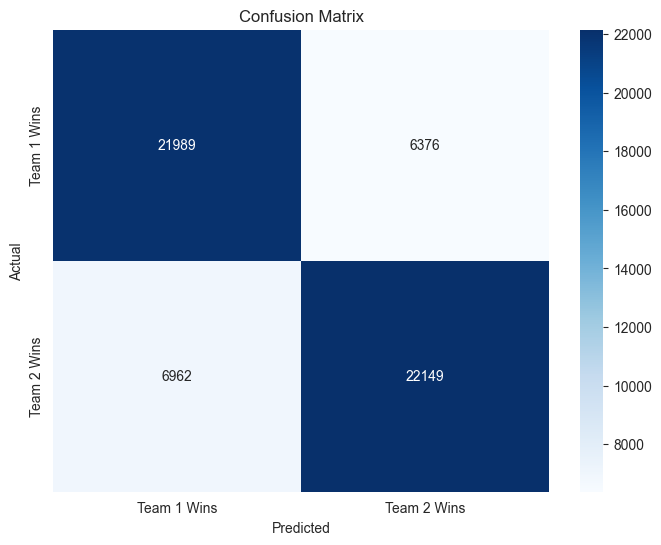

In [164]:
import seaborn as sns
from sklearn.metrics import roc_auc_score

#rf_model2 = RandomForestClassifier(n_estimators=150)
rf_model2 = GradientBoostingClassifier(n_estimators=150)

rf_model2.fit(X_train, y_train)

y_pred = rf_model2.predict(X_test)
y_prob = rf_model2.predict_proba(X_test)[:, 1]  # Probability of class 1 (Team 2 winning)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print basic metrics
print(f"\nRandom Forest Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Team 1 Wins', 'Team 2 Wins'],
            yticklabels=['Team 1 Wins', 'Team 2 Wins'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Top 15 Important Features:
             Feature  Importance
1   Team1_RoundScore    0.192548
2   Team2_RoundScore    0.189267
0        RoundNumber    0.106812
11        team1_raze    0.021659
30        team2_jett    0.021211
28        team2_raze    0.021135
5        team1_reyna    0.020996
15     team1_killjoy    0.020695
13        team1_jett    0.020376
9         team1_sage    0.020328
26        team2_sage    0.020153
22       team2_reyna    0.019190
6       team1_breach    0.018873
7       team1_cypher    0.018864
24      team2_cypher    0.018456


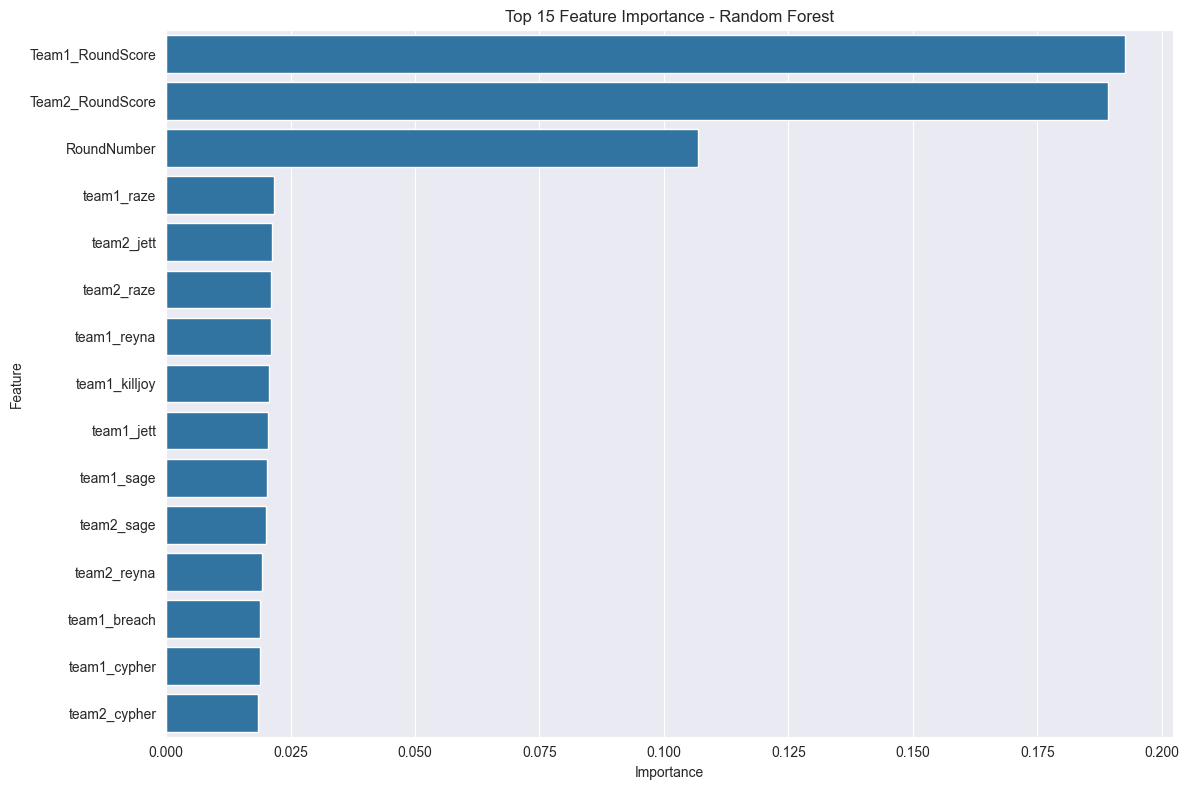

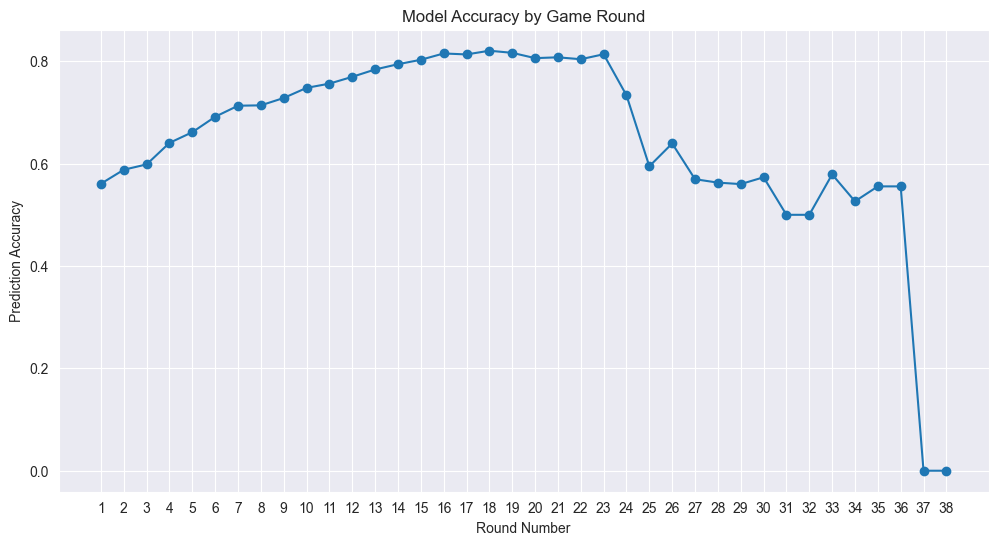


Accuracy by round:
Round 1: 0.5607
Round 2: 0.5881
Round 3: 0.5985
Round 4: 0.6405
Round 5: 0.6614
Round 6: 0.6916
Round 7: 0.7132
Round 8: 0.7139
Round 9: 0.7283
Round 10: 0.7480
Round 11: 0.7563
Round 12: 0.7696
Round 13: 0.7840
Round 14: 0.7942
Round 15: 0.8029
Round 16: 0.8153
Round 17: 0.8133
Round 18: 0.8206
Round 19: 0.8165
Round 20: 0.8061
Round 21: 0.8077
Round 22: 0.8040
Round 23: 0.8137
Round 24: 0.7335
Round 25: 0.5948
Round 26: 0.6394
Round 27: 0.5695
Round 28: 0.5629
Round 29: 0.5600
Round 30: 0.5733
Round 31: 0.5000
Round 32: 0.5000
Round 33: 0.5789
Round 34: 0.5263
Round 35: 0.5556
Round 36: 0.5556
Round 37: 0.0000
Round 38: 0.0000


In [145]:
# Extract and visualize feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model2.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top features
print("\nTop 15 Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Round-by-round prediction accuracy (if applicable)
if 'RoundNumber' in X_test.columns:
    accuracy_by_round = {}
    for round_num in sorted(X_test['RoundNumber'].unique()):
        round_mask = X_test['RoundNumber'] == round_num
        if np.sum(round_mask) > 0:  # Only if we have samples for this round
            round_acc = accuracy_score(
                y_test[round_mask],
                y_pred[round_mask]
            )
            accuracy_by_round[round_num] = round_acc

    plt.figure(figsize=(12, 6))
    rounds = list(accuracy_by_round.keys())
    accuracies = list(accuracy_by_round.values())
    plt.plot(rounds, accuracies, marker='o')
    plt.xlabel('Round Number')
    plt.ylabel('Prediction Accuracy')
    plt.title('Model Accuracy by Game Round')
    plt.xticks(rounds)
    plt.grid(True)
    plt.show()

    print("\nAccuracy by round:")
    for round_num, acc in accuracy_by_round.items():
        print(f"Round {round_num}: {acc:.4f}")


In [156]:
# User inputs for prediction
team1_agents = {"brimstone", "phoenix", "cypher", "jett", "sage"}
team2_agents = {"killjoy", "omen", "sova", "jett", "raze"}
map_to_predict = "Ascent"
current_round_scores = {"Team1_RoundScore": 1, "Team2_RoundScore": 6}

# One-hot encode agents for both teams
team1_encoded = {f'team1_{agent}': int(agent in team1_agents) for agent in all_agents}
team2_encoded = {f'team2_{agent}': int(agent in team2_agents) for agent in all_agents}
map_encoded = {f"{map}": (1 if map == "Map_" + map_to_predict else 0) for map in all_maps}

# Combine all features into a single row
input_features = {
    "RoundNumber": current_round_scores['Team1_RoundScore'] + current_round_scores['Team2_RoundScore'],  # Current round number for prediction
    **current_round_scores,
    **team1_encoded,
    **team2_encoded,
    **map_encoded
}
input_row = pd.DataFrame([input_features])

# Make the prediction
rf_probability = rf_model2.predict_proba(input_row)[0][1] * 100  # Chance of Team1 winning
rf_probability_team2 = 100 - rf_probability

# Display the results
print(f"Map: {map_to_predict}")
print(f"Team1 Composition: {team1_agents}")
print(f"Team2 Composition: {team2_agents}")
print(f"Current Score - Team1: {current_round_scores['Team1_RoundScore']}, "
      f"Team2: {current_round_scores['Team2_RoundScore']}")
print(f"Chance of Team1 winning: {rf_probability:.2f}%")
print(f"Chance of Team2 winning: {rf_probability_team2:.2f}%")

Map: Ascent
Team1 Composition: {'cypher', 'phoenix', 'sage', 'brimstone', 'jett'}
Team2 Composition: {'sova', 'raze', 'killjoy', 'omen', 'jett'}
Current Score - Team1: 1, Team2: 6
Chance of Team1 winning: 20.50%
Chance of Team2 winning: 79.50%


In [157]:
import pickle

with open('random_forest_model2.pkl', 'wb') as f:
    pickle.dump(rf_model2, f)

print("Model has been saved to 'random_forest_model2.pkl'")

Model has been saved to 'random_forest_model2.pkl'


In [61]:
from pandas import json_normalize
import ast

json_data = ast.literal_eval(rounds_filtered.iloc[0]['RoundHistory'])
#flat_df = json_normalize(json_data)
print(json_data[1], len(json_data))

rounds_filtered.set_index('GameID').sort_index()['10003':'10007']
json_data

{'RoundWinner': 'BOOS', 'ScoreAfterRound': '1-0', 'WinType': 'elim', 'Team1Bank': 300.0, 'Team2Bank': 100.0, 'Team1BuyType': 'eco', 'Team2BuyType': 'eco'} 20


{1: {'RoundWinner': 'BOOS',
  'ScoreAfterRound': '1-0',
  'WinType': 'elim',
  'Team1Bank': 300.0,
  'Team2Bank': 100.0,
  'Team1BuyType': 'eco',
  'Team2BuyType': 'eco'},
 2: {'RoundWinner': 'BOOS',
  'ScoreAfterRound': '2-0',
  'WinType': 'elim',
  'Team1Bank': 2700.0,
  'Team2Bank': 8600.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'eco'},
 3: {'RoundWinner': 'BOOS',
  'ScoreAfterRound': '3-0',
  'WinType': 'elim',
  'Team1Bank': 12300.0,
  'Team2Bank': 400.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'full-buy'},
 4: {'RoundWinner': 'BOOS',
  'ScoreAfterRound': '4-0',
  'WinType': 'elim',
  'Team1Bank': 23600.0,
  'Team2Bank': 9800.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'semi-eco'},
 5: {'RoundWinner': 'PHO ',
  'ScoreAfterRound': '4-1',
  'WinType': 'boom',
  'Team1Bank': 24200.0,
  'Team2Bank': 3300.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'full-buy'},
 6: {'RoundWinner': 'PHO ',
  'ScoreAfterRound': '4-2',
  'WinType': 'boom',
  'Team1Bank': 102

In [17]:
# DO NOT TAKE INTO ACCOUNT CODE PAST THIS AREA: IT WAS FROM BEFORE I GOT THINGS WORKING!!!

# Part 1 goal:
# Find the chance of a chosen combination of agents winning
# against another combination of agents. First step will be
# finding overall win rate for a combination of agents.

agents = scoreboard['Agent'].unique()
print(agents, len(agents))

# Example: Extract unique agents (already done earlier)
agents = scoreboard['Agent'].unique()

# Use team_compositions (teams with sets of agents) to create one-hot encoding
def one_hot_encode_team_compositions(team_compositions, all_agents):
    # 'all_agents' defines the feature space (columns)
    encoded_data = []
    team_index = []

    for idx, agents_set in team_compositions.items():
        # For each team composition, generate a binary array for all agents
        encoded_row = [1 if agent in agents_set else 0 for agent in all_agents]
        encoded_data.append(encoded_row)
        team_index.append(idx)  # Keep track of MultiIndex values (GameID, TeamAbbreviation)

    # Create a DataFrame with one-hot encoded rows, indexed by (GameID, TeamAbbreviation)
    one_hot_df = pd.DataFrame(
        encoded_data,
        columns=all_agents,
        index=pd.MultiIndex.from_tuples(team_index, names=team_compositions.index.names)
    )
    return one_hot_df


# Apply the one-hot encoding function
one_hot_team_comps = one_hot_encode_team_compositions(team_compositions['Agent'], agents)

print(one_hot_team_comps.head())
print("THIS IS IT ^^^")

# print(team_compositions.info())
# print(one_hot_team_comps.info())

GameID
60894    Booster Seat Gaming
60895               Pho Real
60896    Booster Seat Gaming
60924         Bjor's Kittens
60925         Bjor's Kittens
Name: Winner, dtype: object
                                                       Agent
GameID TeamAbbreviation                                     
10003  AAA               {sova, raze, phoenix, cypher, omen}
       BRN                 {sova, raze, cypher, reyna, omen}
10004  AAA                 {sova, cypher, reyna, jett, omen}
       BRN                {sova, reyna, jett, omen, killjoy}
10005  AAA                {breach, raze, cypher, jett, omen}
                                                 Agent
TeamAbbreviation                                      
RAD               {viper, astra, sova, reyna, chamber}
same                {viper, sova, cypher, reyna, jett}


In [20]:
team_comps_unique = []
t = 0
for i in team_compositions.index:
    if team_compositions.loc[i]['Agent'] not in team_comps_unique:
        team_comps_unique.append(team_compositions.loc[i]['Agent'])

In [72]:
print(len(team_comps_unique))
print(team_comps_unique[-1])

# Initialize 'who_won' DataFrame based on the team_compositions index
who_won = pd.DataFrame(index=['GameID', 'Team'], columns=["Winner"], dtype=bool)
who_won['Winner'] = True

# Group the DataFrame by GameID
grouped = who_won.groupby(level="GameID")

# Select the 0th row (first row in each group)
first_row_idx = grouped.nth(0).index

# Select the 1st row (second row in each group)
second_row_idx = grouped.nth(1).index

#who_won.loc[first_row_idx, "Winner"] = True if games[]

# for _, row in games.iterrows():
#     game_id = int(row["GameID"])
#     winner = row["Winner"]
#
#     if len(who_won.loc[game_id]) < 2:
#         who_won = who_won.drop(game_id)
#         continue
#     first_row = who_won.loc[game_id].iloc[0].name  # Abbreviation for Team1
#
#     second_row = who_won.loc[game_id].iloc[1].name  # Abbreviation for Team2
#
#     # Update the Winner column directly using index
#     if row["Team1"] == winner:  # Team1 won
#         who_won.at[(game_id, first_row), "Winner"] = True
#         who_won.at[(game_id, second_row), "Winner"] = False
#     elif row["Team2"] == winner:  # Team2 won
#         who_won.at[(game_id, first_row), "Winner"] = False
#         who_won.at[(game_id, second_row), "Winner"] = True


#print(who_won.loc[57193])
games[games['GameID'] == "57193"]

1456
{'sage', 'raze', 'cypher', 'reyna', 'jett'}


,GameID,MatchID,Map,Team1ID,Team2ID,Team1,Team2,Winner,Team1_TotalRounds,Team2_TotalRounds,...,Team1_FullBuyWon,Team2_PistolWon,Team2_Eco,Team2_EcoWon,Team2_SemiEco,Team2_SemiEcoWon,Team2_SemiBuy,Team2_SemiBuyWon,Team2_FullBuy,Team2_FullBuyWon
1375,57193,50407,TBD,6748,6737,ANYWAY,Claquettes cahussettes,ANYWAY,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
agents = scoreboard['Agent'].unique()
print(agents, len(agents))

import pandas as pd

# Example: Extract unique agents (already done earlier)
agents = scoreboard['Agent'].unique()


# Use team_compositions (teams with sets of agents) to create one-hot encoding
def one_hot_encode_team_compositions(team_compositions, all_agents):
    # 'all_agents' defines the feature space (columns)
    encoded_data = []
    team_index = []

    for idx, agents_set in team_compositions.items():
        # For each team composition, generate a binary array for all agents
        encoded_row = [1 if agent in agents_set else 0 for agent in all_agents]
        encoded_data.append(encoded_row)
        team_index.append(idx)  # Keep track of MultiIndex values (GameID, TeamAbbreviation)

    # Create a DataFrame with one-hot encoded rows, indexed by (GameID, TeamAbbreviation)
    one_hot_df = pd.DataFrame(
        encoded_data,
        columns=all_agents,
        index=pd.MultiIndex.from_tuples(team_index, names=team_compositions.index.names)
    )
    return one_hot_df


# Apply the one-hot encoding function
one_hot_team_comps = one_hot_encode_team_compositions(team_compositions['Agent'], agents)

print(one_hot_team_comps.head())
print("THIS IS IT ^^^")

# print(team_compositions.info())
# print(one_hot_team_comps.info())

['jett' 'chamber' 'sova' 'viper' 'skye' 'astra' 'raze' 'sage' 'kayo'
 'killjoy' 'reyna' 'cypher' 'breach' 'omen' 'brimstone' '' 'phoenix'
 'yoru'] 18
                         jett  chamber  sova  viper  skye  astra  raze  sage  \
GameID TeamAbbreviation                                                        
10003  AAA                  0        0     1      0     0      0     1     0   
       BRN                  0        0     1      0     0      0     1     0   
10004  AAA                  1        0     1      0     0      0     0     0   
       BRN                  1        0     1      0     0      0     0     0   
10005  AAA                  1        0     0      0     0      0     1     0   

                         kayo  killjoy  reyna  cypher  breach  omen  \
GameID TeamAbbreviation                                               
10003  AAA                  0        0      0       1       0     1   
       BRN                  0        0      1       1       0     1   
10004

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

reg_model = GradientBoostingRegressor()
reg_model.fit(X_train, y_train)
